## Final Project Module 2: Statistical Analysis and Hypothesis Testing


* Student name: NICK OSELAND
* Student pace: FULL TIME
* Instructor name: RAFAEL CARRASCO

## Table of contents

* [Project Northwind Database](#Project)
* [Question #1](#Question#1)    
* [Question #2](#Question#2)  
* [Question #3](#Question#3)
* [Question #4](#Question#4)
* [Conclusion](#Conclusion)

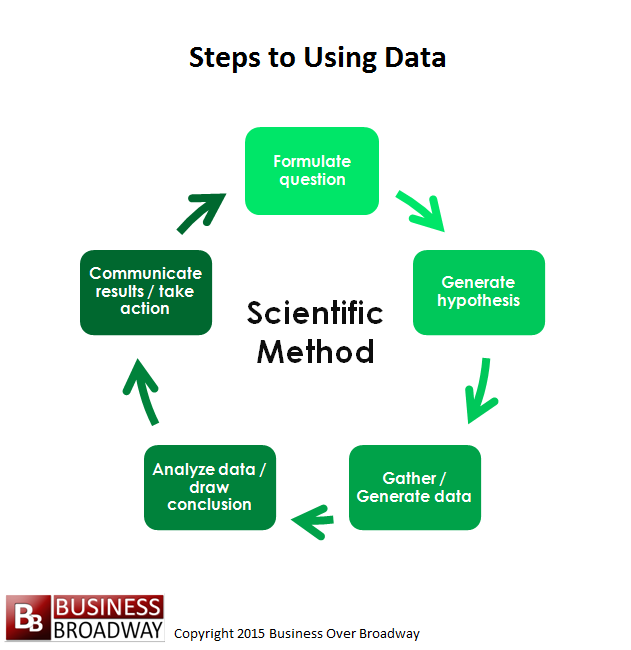

Following prescribed methods, and the directions given, we will take this general approach for each question:
#### 1. EXPLORATORY RESEARCH
- Exploring the existing data
- Feature engineering

#### 2. Define the HYPOTHESIS
- Defining (clearly) the null and alternative hypothesis
- Explaining how to choose between using a one-tailed test (directional hypothesis) or a two-tailed test (non-directional hypothesis)
- Setting significance level

#### 3. STATISTICAL TESTING
- Choosing the appropriate statistical test
- Checking its assumptions
- Calculating test statistic and p-value
- Calculating effect size

#### 4. Drawing CONCLUSIONS 
- Evaluating and interpreting the results

## Project Northwind Database

The Northwind database is a sample database used by Microsoft to demonstrate the features of some of its products, including SQL Server and Microsoft Access. The database contains the sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world.

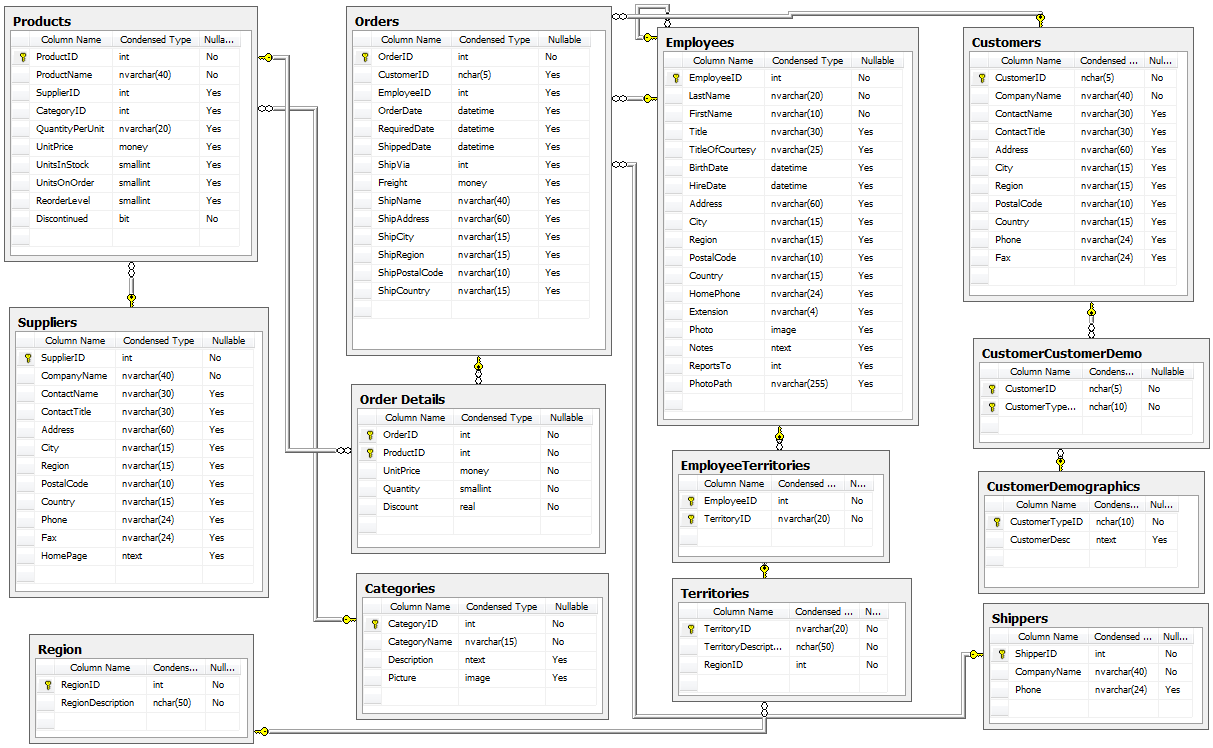

# The Objective

The objective of this project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, we'll need to perform a hypothesis test (or perhaps several) to answer the following questions:

- **Question 1**: Does  applying a discount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
- **Question 2**: Do larger discount amounts affect the sales quantity more than lower discount amounts?
- **Question 3**: Is there a statistically significant difference in the output/performance of shipping companies?
- **Question 4**: Does the time in the year affect the quantity of product sold?

## Importing libraries

In [1]:
import sqlite3 # for database
import pandas as pd # for dataframe
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # analysis
from scipy import stats # significance levels, normality
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

## Connecting to database

In [2]:
# Connecting to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
print(tables)

['Employee', 'Category', 'Customer', 'Shipper', 'Supplier', 'Order', 'Product', 'OrderDetail', 'CustomerCustomerDemo', 'CustomerDemographic', 'Region', 'Territory', 'EmployeeTerritory']


## Converting all tables into dataframes

I was doing this one table at a time, until I ran across this amazing bit of code.

In [4]:
# Loop to put all tables into pandas dataframes
dfs = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # function to make a string into variable name
    # great bit of code I found while researching
    conv = i+"_df"
    exec(conv + " = df") # => TableName_df
    # Keep all dataframe names in the list to remember what we have
    dfs.append(conv)
    print(conv)

Employee_df
Category_df
Customer_df
Shipper_df
Supplier_df
Order_df
Product_df
OrderDetail_df
CustomerCustomerDemo_df
CustomerDemographic_df
Region_df
Territory_df
EmployeeTerritory_df


# Exploratory Data Analysis

In [5]:
Order_df.head(10)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela


In [6]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
OrderDetail_df['Discount'].shape

(2155,)

## Let's take a better look at what we are selling

In [8]:
Product_df.head(30) # change to 77 to see all product descriptions

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
5,6,Grandma's Boysenberry Spread,3,2,12 - 8 oz jars,25.00,120,0,25,0
6,7,Uncle Bob's Organic Dried Pears,3,7,12 - 1 lb pkgs.,30.00,15,0,10,0
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00,29,0,0,1
9,10,Ikura,4,8,12 - 200 ml jars,31.00,31,0,0,0


In [9]:
len(Product_df)

77

In [10]:
# creating 2 populations to work with 
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()

##  Discounted and not discounted products by order quantity

Table `Product` has 77 entries, each entry is unique product

First we can check visually if discount really made a difference in order quantity

In [11]:
def make_dist(arr, bins=40, color='b', alpha=.6):
    plt.figure(figsize=(8,6))
    plt.grid(zorder=0)
    # zorder pushes things in and out of the frame in front of grid
    plt.hist(arr, bins=bins,color=color, alpha=alpha, zorder=3)
    plt.show()

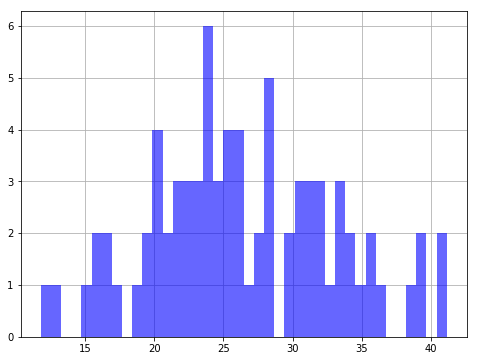

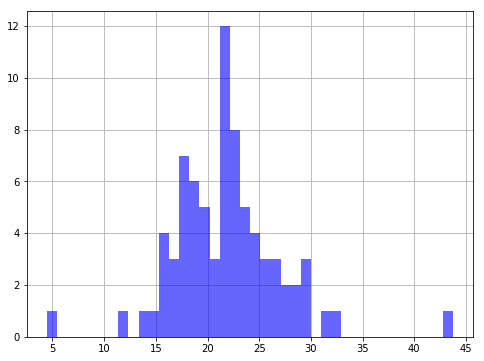

In [12]:
# helps to see distributions
make_dist(discount)
make_dist(no_discount)

In [13]:
print(discount.mean())
print(no_discount.mean())

26.43253285866255
21.81167852821319


In [14]:
# ratio of standard deviation .8 - 1.2 is where you want to be, we are pretty close
np.std(no_discount)/np.std(discount)

0.7851309352711258

In [15]:
# shapiro test, tests for normality of populations
for sv in [no_discount, discount]:
    w, p = scs.shapiro(sv)
    print("p = {}".format(p))

p = 0.0015117175644263625
p = 0.7060348391532898


## Orders by discount level

let us see how many discount levels we have, and how many orders we average per level of discount.

In [16]:
# Let's get all discount levels
discounts = OrderDetail_df['Discount'].unique()
discounts.sort()
print('Discount levels')
print(discounts)

Discount levels
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


These are the different levels of discount that where recorded in the data, 0.04 is = to a 4% discount.

In [17]:
# Group orders by discount amounts
# Each group is a DataFrame containing orders with certain discount level
groups = {}
for i in discounts:
    groups[i] = OrderDetail_df[OrderDetail_df['Discount']==i]

In [18]:
# Create new DataFrame with Discounts and Order quantities
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)

discounts_df

,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,1.0,1.0,2.000000
2,2.0,2.0,2.000000
3,3.0,3.0,1.666667
4,4.0,1.0,1.000000
5,5.0,185.0,28.010811
6,6.0,1.0,2.000000
7,10.0,173.0,25.236994
8,15.0,157.0,28.382166
9,20.0,161.0,27.024845


The table above shows us the average order quantity per level of discount. Two things stand out immediately. First, and most notable is the discount quantities of 1%, 2%, 3%, 4%, and 6% (respectively) all hardly have any sales, and as a result, probably wont be able to help provide much more information. it would probably be safe to drop those discount levels. The second thing I notice, though not as eye grabbing, is the relativley small amount of varience between the rest of the discount %'s(namely:5%,10%,15%,20%,25%), and their corresponding order quantity.

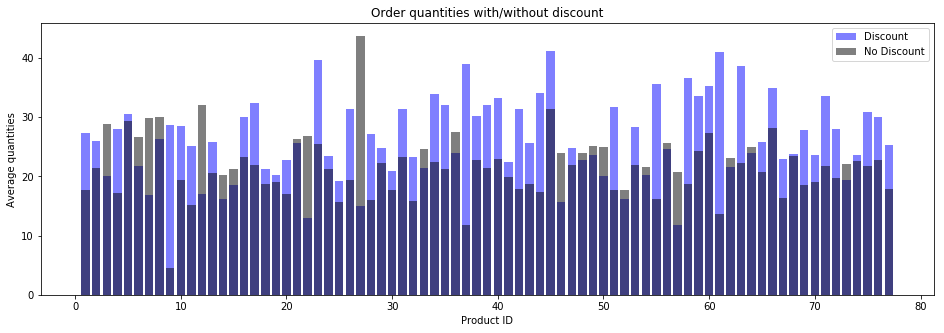

Conclusion
On average 70.0% of discounted products were sold in larger quantities
Average order quantity with Discount - 26.43 items, without Discount - 21.81 items


In [19]:
plt.figure(figsize=(16,5))
plt.bar(discount.index, discount.values, alpha=.5, label='Discount', color='b')
plt.bar(no_discount.index, no_discount.values, alpha=0.5, label='No Discount', color='k')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()

print('Conclusion')
print("On average {}% of discounted products were sold in larger quantities".format(round(sum(discount.values > no_discount.values)/len(discount.values)*100),2))
print("Average order quantity with Discount - {} items, without Discount - {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

At an initial glance, we can see it appears that "Discounted" product on average, has larger quantities of product sold. To prove this, let's run a quick experiment to be certain.

## Visualization

In [20]:
def visualization(control, experimental):
    plt.figure(figsize=(12,8))
    sns.distplot(experimental, bins=80, color=None,  label='Experimental')
    sns.distplot(control, bins=80, color=None,  label='Control')

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='g', linestyle='--')

    plt.title('Control and Experimental Sampling Distributions', fontsize=12)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## Cohen's d

Cohen's d is an effect size used to indicate the standardised difference between two means. It can be used, for example, to accompany reporting of t-test and ANOVA results. It is also widely used in meta-analysis. Cohen's d is an appropriate effect size for the comparison between two means.

In [21]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

## Bootstrap

Bootstrapping is a type of resampling where large numbers of smaller samples of the same size are repeatedly drawn, with replacement, from a single original sample.

In [22]:
def bootstrap(sample, n):
    bootstrap_sampling_dist = []
    for i in range(n):
        bootstrap_sampling_dist.append(np.random.choice(sample, size=len(sample), replace=True).mean())
    return np.array(bootstrap_sampling_dist)

# Question#1

## Does  applying a discount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- $H_0$: there is no difference in order quantity due to discount
- $H_\alpha$: there is a difference in order quantity due to discount

Usually discount increases order quantity, so it would be reasonable to perform one-tailed test with $\alpha$ set to 0.025. If $p$ < $\alpha$, we reject null hypothesis.

## Welch's T-test

In statistics, Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to test the hypothesis that two populations have equal means.

I created two distributions (control and experimental). Control distribution includes only order quantities without discounts, and the experimental distribution includes order quantities with discounts (at any level)

This experiment would answer a question if there is any difference in purchase quantity

In [23]:
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
experimental = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

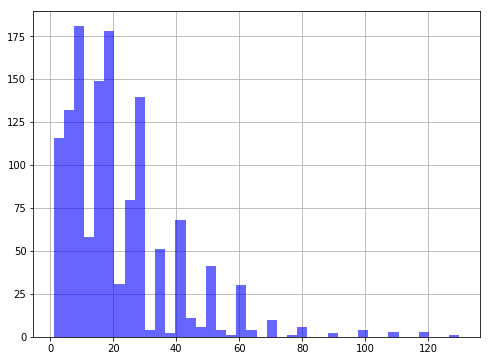

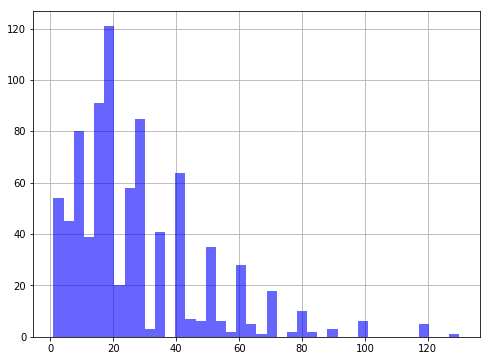

In [24]:
make_dist(control)
make_dist(experimental)

2 tailed test

Reject Null Hypothesis
Cohen's d: 0.2862724481729283


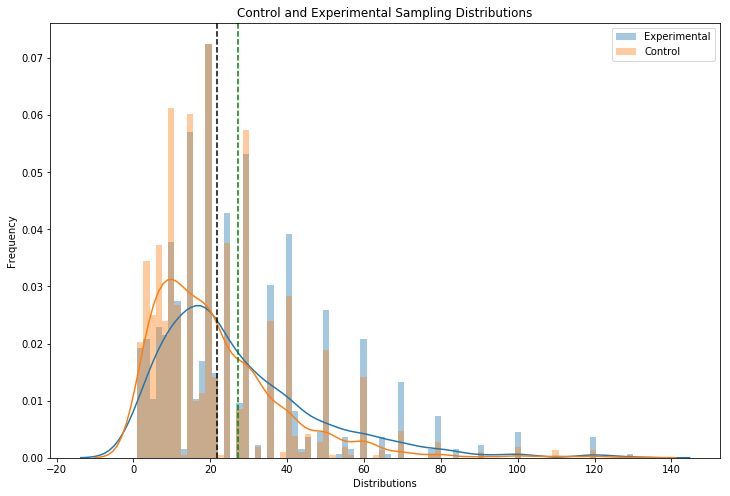

In [25]:
t_stat, p = stats.ttest_ind(control, experimental)
d = Cohen_d(experimental, control)

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d)
visualization(control, experimental)

### Result

This shows us that there is in fact a _**statistically significant**_ difference in the amount of orders, therefore we can reject the null hypothesis with confidence. The question was posed in such a way that it asks if order quantity is different at different discount levels. The next step (part 2 of first question) is to find out specifically at what discount level does the change in order quantities become _**statisticaly significant**_. 
To show this, we will run the previous experiment again, but we will make distinctions by grouping discount amounts.

In [26]:
discounts_significance_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None)

discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for i in discounts:
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control, experimental)
    d = Cohen_d(experimental, control)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'Null Hypothesis' : 'Reject' if p < 0.025 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discounts_significance_df

,Discount %,Null Hypothesis,Cohens d
0,5.0%,Reject,0.346877
1,10.0%,Reject,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


These results show us that the remaining discount percentages (5%, 10%, 15%, 20%, 25%) less the ones we dropped earlier (1%,2%,3%,4%, and 6%), show a _**statistically significant**_ difference in order quantities then those having no discount.



Something is still bothering me though.... we now know that of the discount percentages we encountered, 5%, 10%, 15%, 20%, 25% all showed a _**statistically significant**_ difference in order quantities from 0 or no discounts (less the few "odd ball" discounts that didnt have enough order quantities to validate working with them). which is great, and we were able to validate with an experiment, even better. However, as I had mentioned earlier from a simple observation early on, there was not a lot of discernable difference (at a glance) in order quantities between discounts 5%, 10%, 15%, 20%, and 25%. That stands out as strange to me. Since we were able to conclude that applying a discount does in fact have a positive correlation to quantities sold, the findings lead me to the second question I want to ask.  

# Question#2

## Do larger discount amounts affect the sales quantity more than lower discount amounts?


- $H_0$: there is no difference in order quantity between discount rates.
- $H_\alpha$: there is a difference in order quantity between discount rates.

1 tailed test

In [27]:
discounts = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
# itertools.combinations works through every single combination without repeating a combination 
comb = itertools.combinations(discounts,2 )
discount_levels_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None)

for i in comb:
    
    control =      OrderDetail_df[OrderDetail_df['Discount']==i[0]]['Quantity']
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i[1]]['Quantity']
    
    st, p = stats.ttest_ind(experimental, control)
    d = Cohen_d(experimental, control)
    
    discount_levels_df = discount_levels_df.append( { 'Discount %' : str(i[0]*100)+'% - '+str(i[1]*100)+'%', 'Null Hypothesis' : 'Reject' if p < 0.05 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discount_levels_df.sort_values('Cohens d', ascending=False)

,Discount %,Null Hypothesis,Cohens d
4,10.0% - 15.0%,Failed,0.149332
6,10.0% - 25.0%,Failed,0.145146
0,5.0% - 10.0%,Failed,0.127769
5,10.0% - 20.0%,Failed,0.089008
7,15.0% - 20.0%,Failed,0.068234
9,20.0% - 25.0%,Failed,0.062415
2,5.0% - 20.0%,Failed,0.047644
1,5.0% - 15.0%,Failed,0.017179
3,5.0% - 25.0%,Failed,0.010786
8,15.0% - 25.0%,Failed,0.006912


### Result

Result of the test shows that there is no _**statistically significant**_ difference in order quantity between discounts of 5%, 10%, 15%, 20% and 25%. This means we failed to reject the null hypothesis. This is not surprising based off our initial results, but I still find it very interesting information to know, and usefull. If you have stock that needs to be unloaded quickly, a 5% discount is likely to get the product out of the door just as fast as a 25% discount, from the data gathered thus far. The results could be used to further investigate and maybe test the effect of different discount levels as potential revenue boosters.

# Question#3
## Is there a statistically significant difference in the output of shipping companies?

- $H_0$: There is no difference in level of performance between categories
- $H_\alpha$: There is a difference in level of performance between categories

In [28]:
Order_df.head(15)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,13.97,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil
9,10257,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela


In [29]:
Order_df['ShipRegion'].head()

0    Western Europe
1    Western Europe
2     South America
3    Western Europe
4    Western Europe
Name: ShipRegion, dtype: object

In [30]:
Order_df['ShipRegion'].unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [31]:
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [32]:
Order_df.OrderDate = pd.to_datetime(Order_df.OrderDate)
Order_df.ShippedDate = pd.to_datetime(Order_df.ShippedDate)
Order_df.RequiredDate = pd.to_datetime(Order_df.RequiredDate)

Order_df['ProcessingTime'] = Order_df.ShippedDate - Order_df.OrderDate
Order_df['ShippingTime'] = Order_df.RequiredDate - Order_df.ShippedDate

Order_df.ShippingTime = Order_df.ShippingTime.dt.days
Order_df.ProcessingTime = Order_df.ProcessingTime.dt.days

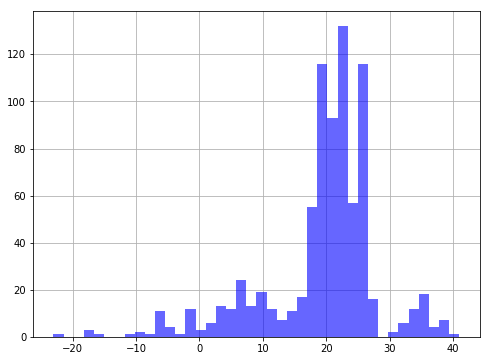

In [33]:
make_dist(Order_df.ShippingTime)

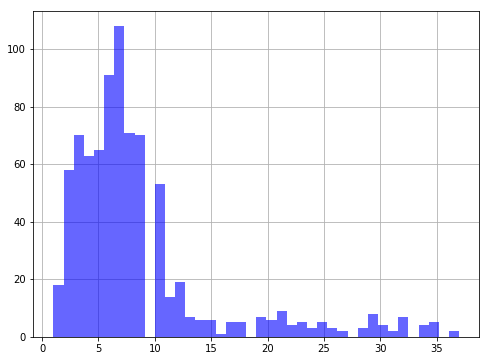

In [34]:
make_dist(Order_df.ProcessingTime)

In [35]:
Order_df['ShippingTime'].head(15)

0     16.0
1     37.0
2     24.0
3     21.0
4     26.0
5      8.0
6     16.0
7     25.0
8     26.0
9     22.0
10    22.0
11    21.0
12    18.0
13    17.0
14    25.0
Name: ShippingTime, dtype: float64

In [36]:
Order_df['ProcessingTime'].head(15)

0     12.0
1      5.0
2      4.0
3      7.0
4      2.0
5      6.0
6     12.0
7      3.0
8      2.0
9      6.0
10     6.0
11     7.0
12    10.0
13    11.0
14     3.0
Name: ProcessingTime, dtype: float64

In [37]:
Order_df.ProcessingTime.head(15)

0     12.0
1      5.0
2      4.0
3      7.0
4      2.0
5      6.0
6     12.0
7      3.0
8      2.0
9      6.0
10     6.0
11     7.0
12    10.0
13    11.0
14     3.0
Name: ProcessingTime, dtype: float64

In [38]:
Order_df.ProcessingTime.mean()

8.491965389369591

In [39]:
Order_df.groupby('ShipVia').mean()

,Id,EmployeeId,Freight,ProcessingTime,ShippingTime
ShipVia,,,,,
1,10667.594378,4.232932,65.001325,8.571429,19.485714
2,10674.963190,4.536810,86.640644,9.234921,18.765079
3,10641.592157,4.400000,80.441216,7.473896,19.963855


### ANOVA Test

Analysis of variance (ANOVA) is a statistical technique that is used to check if the means of two or more groups are significantly different from each other. ... When we have only two samples, t-test and ANOVA give the same results. However, using a t-test would not be reliable in cases where there are more than 2 samples

In [40]:
formula = 'ProcessingTime ~ C(ShipVia)'
lm = ols(formula, Order_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F    PR(>F)
C(ShipVia)    433.501581    2.0  4.676819  0.009563
Residual    37354.696194  806.0       NaN       NaN


In [41]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ProcessingTime   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.677
Date:                Sun, 16 Jun 2019   Prob (F-statistic):            0.00956
Time:                        11:14:28   Log-Likelihood:                -2698.1
No. Observations:                 809   AIC:                             5402.
Df Residuals:                     806   BIC:                             5416.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.5714      0.435     19.707      0.000       7.718       9.425
C(ShipVia)[T.2]     0.6635      0.580      1.144      0.253      -0.475       1.802
C(ShipVia)[T.3]    -1.0975      0.613     -1.792      0.074      -2.300       0.105
==============================================================================
Omnibus:                      338.799   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1191.616
Skew:                           2.055   Prob(JB):                    1.75e-259
Kurtosis:                       7.296   Cond. No.                         3.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result

Result of the test shows that there is a _**statistically significant**_ difference in performance of shipping companies, hence we reject null hypothesis

# Question#4
## Are there any times in the year where demand is higher than others, or lower?

- $H_0$: There is no difference in demand of produce each month
- $H_\alpha$: There is a difference in demand of produce each month

### Read Database

In [42]:
produce = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 7

''',conn)   

In [43]:
produce.head(15)

,OrderDate,Quantity,Discount,CategoryId
0,2012-07-05,9,0.00,7
1,2012-07-05,40,0.00,7
2,2012-07-08,35,0.15,7
3,2012-07-11,21,0.00,7
4,2012-07-22,15,0.00,7
5,2012-07-23,36,0.25,7
6,2012-08-09,20,0.00,7
7,2012-08-27,2,0.10,7
8,2012-09-10,28,0.00,7
9,2012-09-23,4,0.00,7


### Group by month

In [44]:
produce.OrderDate = pd.to_datetime(produce.OrderDate)
produce['Month'] = produce.OrderDate.dt.month

In [45]:
produce['Month'].head()

0    7
1    7
2    7
3    7
4    7
Name: Month, dtype: int64

In [46]:
produce.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,16.545455,0.050000,7.0
2,15.555556,0.011111,7.0
3,21.500000,0.004545,7.0
4,29.105263,0.028947,7.0
5,12.888889,0.075556,7.0
6,21.285714,0.085714,7.0
7,26.375000,0.050000,7.0
8,15.666667,0.038889,7.0
9,17.500000,0.025000,7.0


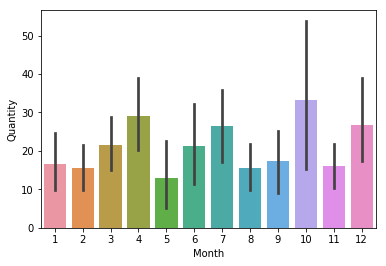

In [47]:
sns.barplot(produce['Month'],produce['Quantity'])
#plt.figure(figsize=(12,8))
plt.show()

### ANOVA Test

In [48]:
formula = 'Quantity ~ C(Month)'
lm = ols(formula, produce).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   4834.012843   11.0  1.318794  0.221691
Residual  41319.957745  124.0       NaN       NaN


### Result

There is a _**statistically significant**_ difference in order quantity between months, hence we reject the null hypothesis

# Conclusion

- There is a statistically significant difference in the order quantity of products that have had a discount applied. it becomes significant at the 5% discount and remains significant up to 25%, less the percentages dropped.
- There is no statistically significant difference in order quantity between discounts of 5%, 10%, 15%, 20% and 25%.
- There is a statistically significant difference in performance of shipping companies.
- Total order quantities vary a statistically significant amount from month to month. with April, July, October, and December being the highest volume months (October is the highest).

# recommendations

- We now have confirmed that using discounts is still a viable option when trying to move larger quantities of goods, or improve the item count in a single order, not earth shattering information, but still good to have confirmed. 
- I do however recommend that from this point forward, we experiment with teh level of discount and gather more data on sales quantities, as well as comparing per sale profit margins of the different discount levels.
- I recommend that we look further into our shipping contracts as well. While we were able to confirm that they do produce different levels of performance, without filling in more of the picture, I can't really make any concrete statements about what these figures mean, other then saying our 3 shipping companies do not perform equally across the board.
- In regards to sale fluctuations month to month, again, this doesn't do much by its self. However, I do feel that this is highlighting missed opportunties. Since we know what months we will see more traffic through our site, we need to make sure we are doing everything we can during these periods of increased customer traffic to promote ourselves and our products for the upcoming months/events....

### Future Steps

- Look further into shipping, namely regions covered, size of area covered, & potential ways to improve logistics.
- Look into tracking individual employee performance levels.
- try to better identify who our customers are, and what makes them buy from us.
- Look into discounts and sales figures from months with higher sales, see if they behave the same as months with lower sales.
- begin experimenting with offering different discount levels in order continue gathering data on what discount levels move the most amount of product out the door, as well as better determining at what level of discount will see diminished returns despite volume of product sold.